## Batch loading of image data
### Brett Olsen, April 2023

This is an extension of earlier posted work using zarr to store chunked fragment volume data.
This notebook shows how to use this chunked data to train with all the training data by swapping between different slices of the data that are small enough to hold in memory.

In [1]:
GITHUB_REPO_URL = "https://github.com/caethan/vesuvius_image.git"
!git clone {GITHUB_REPO_URL}
!git -C /kaggle/working/vesuvius_image/ pull

Cloning into 'vesuvius_image'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 42 (delta 17), reused 25 (delta 6), pack-reused 0
Receiving objects: 100% (42/42), 14.67 KiB | 2.44 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Already up to date.


In [2]:
import sys
import os
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
# We're using this context manager to do our conda env update without massively cluttering up the output
with HiddenPrints():
    !mamba env update --name base --file vesuvius_image/conda_env.yaml

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [5]:
if "/kaggle/working/vesuvius_image/" not in sys.path:
    sys.path.append("/kaggle/working/vesuvius_image/")

In [6]:
from vesuvius.image import PapyrusImage
from vesuvius.volume import PapyrusVolume
from vesuvius.utils import Timer

from tqdm import tqdm
import numpy as np
from typing import Union
import scipy
import matplotlib.pyplot as plt

In [11]:
INPUT_FOLDER = "/kaggle/input/vesuvius-challenge-ink-detection/"
WORKING_FOLDER = "/kaggle/working/"

In [12]:
# This cell will generate the zarr files if they don't already exist.
# Note we're running with "multiscale=False" to avoid using more space than we need for the
# downsampled copies.
for subdir in ["1", "2", "3"]:
    train_input_dir = os.path.join(INPUT_FOLDER, "train", subdir)
    train_output_dir = os.path.join(WORKING_FOLDER, f"train_{subdir}")
    os.makedirs(train_output_dir, exist_ok=True)
    print(train_output_dir)
    # First the surface volume stack
    frag_output = os.path.join(train_output_dir, "frag.volzarr")
    if not os.path.exists(frag_output):
        # TODO: experiment with different chunk sizes here
        PapyrusVolume.build_from_tiffdir(
            os.path.join(train_input_dir, "surface_volume"), 
            frag_output, 
            multiscale=False,
        )
    # The fragment mask
    mask_output = os.path.join(train_output_dir, "mask.imagezarr")
    if not os.path.exists(mask_output):
        PapyrusImage.build_from_image(
            os.path.join(train_input_dir, "mask.png"),
            mask_output,
            multiscale=False,
        )
    # The truth set
    ink_output = os.path.join(train_output_dir, "inklabels.imagezarr")
    if not os.path.exists(ink_output):
        PapyrusImage.build_from_image(
            os.path.join(train_input_dir, "inklabels.png"),
            ink_output,
            multiscale=False
        )

/kaggle/working/train_1
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/1/surface_volume
Loading file /kaggle/input/vesuvius-challenge-ink-detection/train/1/surface_volume/64.tif
Loading tiff files: 113.5469 seconds
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/1/mask.png
Loading image data: 0.1739 seconds
Storing full image data: 0.5860 seconds
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/1/inklabels.png
Loading image data: 0.1805 seconds
Storing full image data: 0.5013 seconds
/kaggle/working/train_2
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/2/surface_volume
Loading file /kaggle/input/vesuvius-challenge-ink-detection/train/2/surface_volume/64.tif
Loading tiff files: 342.2740 seconds
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/2/mask.png


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:3170: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Loading image data: 0.4676 seconds
Storing full image data: 1.6681 seconds
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/2/inklabels.png
Loading image data: 0.4410 seconds
Storing full image data: 1.5050 seconds
/kaggle/working/train_3
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/3/surface_volume
Loading file /kaggle/input/vesuvius-challenge-ink-detection/train/3/surface_volume/64.tif
Loading tiff files: 96.3454 seconds
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/3/mask.png
Loading image data: 0.1267 seconds
Storing full image data: 0.5278 seconds
Building zarr from /kaggle/input/vesuvius-challenge-ink-detection/train/3/inklabels.png
Loading image data: 0.1268 seconds
Storing full image data: 0.4843 seconds


In [13]:
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
Z_SLICE = slice(Z_START, Z_START + Z_DIM, None)


SUBFOLDERS = ["train_1", "train_2", "train_3"]

def load_data_slice(query_index, max_mem=1e9, count_only=False):
    """Loads a subset of the training data into GPU memory.  Slicing is done so as to
    produce roughly square regions of each dataset so that the slices do not exceed
    the required maximum memory size.
    
    Note that the mask data is only loaded into CPU, not onto GPU.
    """
    # one float stored for the labels and one for each level of Z used
    bytes_per_pixel = (Z_DIM + 1) * np.dtype("float32").itemsize
    
    slice_index = 0
    for subfolder in SUBFOLDERS:
        if count_only:
            print(slice_index)
        with HiddenPrints():
            labelzarr = PapyrusImage(f"{WORKING_FOLDER}/{subfolder}/inklabels.imagezarr")
            fragzarr = PapyrusVolume(f"{WORKING_FOLDER}/{subfolder}/frag.volzarr")
            maskzarr = PapyrusImage(f"{WORKING_FOLDER}/{subfolder}/mask.imagezarr")
        
        # Keep cutting the largest dimensions in half until we're small enough to fit
        # in our memory limits.
        xsize, ysize = labelzarr.shape
        xcount, ycount = 1, 1
        while (xsize + BUFFER) * (ysize + BUFFER) * bytes_per_pixel > max_mem:
            if xsize > ysize:
                xsize = xsize // 2
                xcount += 1
            else:
                ysize = ysize // 2
                ycount += 1
        for x in range(xcount):
            for y in range(ycount):
                if (slice_index == query_index) and not count_only:
                    xslice = slice(max(0, xsize * x - BUFFER),
                                   min(labelzarr.shape[0], xsize * (x + 1) + BUFFER),
                                   None)
                    yslice = slice(max(0, ysize * y - BUFFER),
                                   min(labelzarr.shape[1], ysize * (y + 1) + BUFFER),
                                   None)
                    labels = torch.from_numpy(
                        labelzarr[xslice,yslice,0].astype(np.float32)
                    ).to(DEVICE)
                    surface_volume = torch.from_numpy(
                        fragzarr[xslice,yslice,Z_SLICE,0].astype(np.float32) / np.iinfo(np.uint16).max
                    ).to(DEVICE)
                    mask = maskzarr[xslice,yslice,0]
                    return labels, surface_volume, mask
                slice_index += 1
    
    if count_only:
        return slice_index
    
    raise ValueError(f"Query index {query_index} too large; only {slice_index} slices of data.")
      
# Here we're running it with "count_only" so that we can see how many slices of data there
# are in our zarrs.
total_slices = load_data_slice(0, max_mem=1e9, count_only=True)
print(total_slices)

0
4
10
12


Great.  So there's 12 total slices, slices 0-3 are from fragment 1, slices 4-9 are from fragment 2, and slices 10-11 are from fragment 3.
We'll select one slice from each fragment to be validation data and the remaining slices will provide training data.

In [14]:
validation_slices = [2, 6, 11]
training_slices = [i for i in range(total_slices) if i not in validation_slices]
print(training_slices)

[0, 1, 3, 4, 5, 7, 8, 9, 10]


Now we will generate a custom PyTorch dataset:  if provided with a given slice index, it will load
the data from that slice into GPU memory.
Then every pixel (within the mask) inside that slice is available to access a small region around that pixel.

In [15]:
class SlicedDataset(data.Dataset):
    def __init__(self, query_slice):
        self.query_slice = query_slice
        labels, surface_volume, mask = load_data_slice(query_slice)
        self.labels = labels
        self.surface_volume = surface_volume
        self.mask = mask
        self.xvals, self.yvals = np.where(self.mask)
        xmask = ((self.xvals - BUFFER) > 0) & ((self.xvals + BUFFER) < self.labels.shape[0])
        ymask = ((self.yvals - BUFFER) > 0) & ((self.yvals + BUFFER) < self.labels.shape[1])
        self.xvals = self.xvals[xmask & ymask]
        self.yvals = self.yvals[xmask & ymask]
        
    def __len__(self):
        return len(self.xvals)
    
    def __getitem__(self, index):
        x = self.xvals[index]
        y = self.yvals[index]
        subvolume = self.surface_volume[x-BUFFER:x+BUFFER+1, y-BUFFER:y+BUFFER+1, :].view(1, BUFFER*2+1, BUFFER*2+1, Z_DIM)
        inklabel = self.labels[x, y].view(1)
        return x, y, subvolume, inklabel

And here's a dead simple neural network model (the same one used for the demo from the organizers).
But now I'll show how to train and validate this model with the entire data from all three fragments.

In [16]:
model = nn.Sequential(
    nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.MaxPool3d(kernel_size=2, stride=2),
    #Flattens dimensions 1+ into a single dimension, so it is a dim=2 matrix afterwards
    nn.Flatten(start_dim=1),
    nn.LazyLinear(out_features=128),
    nn.ReLU(),
    nn.LazyLinear(out_features=1),
    # Convert from (-inf, inf) to (0, 1) probability with a sigmoid
    nn.Sigmoid()
).to(DEVICE)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Now we're going to train (badly) our model to show how we load data from different slices in and out of GPU memory. 

In [18]:
training_losses = []
validation_losses = []

In [19]:
print("Training...")
TRAINING_STEPS_PER_SLICE = 64
LEARNING_RATE = 0.03
BATCH_SIZE = 16
EPOCH_COUNT = 5

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

for i in range(EPOCH_COUNT):
    print(f"Processing epoch {i+1}")

    epoch_training_loss = [0.0, 0]
    for tr_item in training_slices:
        train_dataset = SlicedDataset(tr_item)
        if len(train_dataset) == 0:
            # Just in case one of the slices is entirely empty (because of the mask)
            continue
        print(f"Training on data slice {tr_item}")
        training_steps = min(len(train_dataset), TRAINING_STEPS_PER_SLICE)
        train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=LEARNING_RATE, total_steps=training_steps
        )
        model.train()
        for i, (_, _, subvolumes, inklabels) in enumerate(train_loader):
            if i >= training_steps:
                break
            optimizer.zero_grad()
            outputs = model(subvolumes.to(DEVICE))
            loss = criterion(outputs, inklabels.to(DEVICE))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_training_loss[0] += loss.item()
            epoch_training_loss[1] += 1
        del train_dataset, train_loader, scheduler, _, loss, subvolumes, inklabels
        torch.cuda.empty_cache()
    training_losses.append(epoch_training_loss[0] / epoch_training_loss[1])
        
    val_training_loss = [0.0, 0]
    for val_item in validation_slices:
        val_dataset = SlicedDataset(val_item)
        if len(val_dataset) == 0:
            continue
        print(f"Validating on data slice {val_item}")
        val_steps = min(len(val_dataset), TRAINING_STEPS_PER_SLICE)
        val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
        model.eval()
        with torch.no_grad():
            for i, (_, _, subvolumes, inklabels) in enumerate(val_loader):
                if i > val_steps:
                    break
                outputs = model(subvolumes.to(DEVICE))
                loss = criterion(outputs, inklabels.to(DEVICE))
                val_training_loss[0] += loss.item()
                val_training_loss[1] += 1
        del val_dataset, val_loader, _, loss, subvolumes, inklabels
        torch.cuda.empty_cache()
    validation_losses.append(val_training_loss[0] / val_training_loss[1])
        
del optimizer
torch.cuda.empty_cache()

Training...
Processing epoch 1
Training on data slice 0
Training on data slice 1
Training on data slice 3
Training on data slice 4
Training on data slice 5
Training on data slice 7
Training on data slice 8
Training on data slice 9
Training on data slice 10
Validating on data slice 2
Validating on data slice 6
Validating on data slice 11
Processing epoch 2
Training on data slice 0
Training on data slice 1
Training on data slice 3
Training on data slice 4
Training on data slice 5
Training on data slice 7
Training on data slice 8
Training on data slice 9
Training on data slice 10
Validating on data slice 2
Validating on data slice 6
Validating on data slice 11
Processing epoch 3
Training on data slice 0
Training on data slice 1
Training on data slice 3
Training on data slice 4
Training on data slice 5
Training on data slice 7
Training on data slice 8
Training on data slice 9
Training on data slice 10
Validating on data slice 2
Validating on data slice 6
Validating on data slice 11
Process

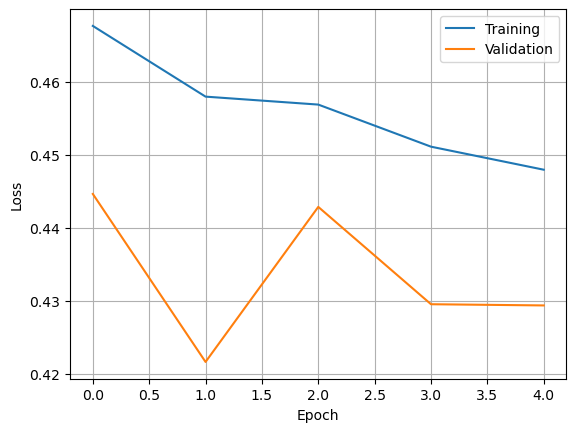

In [20]:
plt.figure()
plt.grid()

plt.plot(training_losses, label="Training")
plt.plot(validation_losses, label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

So you can see that the model and training performance is pretty bad, but the actual data loading works fine:  we just work with each bit of memory separately for either training, validation, or inference.